In [2]:
from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt



from scipy.io import loadmat



%matplotlib inline  

M = loadmat("mnist_all.mat")



def get_test(M):
    batch_xs = np.zeros((0, 28*28))
    batch_y_s = np.zeros( (0, 10))
    
    test_k =  ["test"+str(i) for i in range(10)]
    for k in range(10):
        batch_xs = np.vstack((batch_xs, ((np.array(M[test_k[k]])[:])/255.)  ))
        one_hot = np.zeros(10)
        one_hot[k] = 1
        batch_y_s = np.vstack((batch_y_s,   np.tile(one_hot, (len(M[test_k[k]]), 1))   ))
    return batch_xs, batch_y_s


def get_train(M):
    batch_xs = np.zeros((0, 28*28))
    batch_y_s = np.zeros( (0, 10))
    
    train_k =  ["train"+str(i) for i in range(10)]
    for k in range(10):
        batch_xs = np.vstack((batch_xs, ((np.array(M[train_k[k]])[:])/255.)  ))
        one_hot = np.zeros(10)
        one_hot[k] = 1
        batch_y_s = np.vstack((batch_y_s,   np.tile(one_hot, (len(M[train_k[k]]), 1))   ))
    return batch_xs, batch_y_s
        

train_x, train_y = get_train(M)
test_x, test_y = get_test(M)



train_x, train_y = get_train(M)
test_x, test_y = get_test(M)

dim_x = 28*28
dim_h = 20
dim_out = 10

dtype_float = torch.cuda.FloatTensor
dtype_long = torch.cuda.LongTensor



################################################################################
#Subsample the training set for faster training

train_idx = np.random.permutation(range(train_x.shape[0]))[:1000]
x = Variable(torch.from_numpy(train_x[train_idx]), requires_grad=False).type(dtype_float)
y_classes = Variable(torch.from_numpy(np.argmax(train_y[train_idx], 1)), requires_grad=False).type(dtype_long)
#################################################################################


`x`, `y`, and `y_classes` are PyTorch Variables. We will now define the neural network model. We'll use `toch.nn.Sequential`

In [3]:
model = torch.nn.Sequential(
    torch.nn.Linear(dim_x, dim_h),
    torch.nn.ReLU(),
    torch.nn.Linear(dim_h, dim_out),
).cuda()

`model` can be used to apply the network to `Variable` inputs.

We'll define a loss function using `torch.nn.CrossEntropyLoss()`, which computes the cross entropy from the logits  of the class probability (i.e., outputs of the softmax) and the class labels (i.e., the average negative log-probability of the correct answer).

In [4]:
loss_fn = torch.nn.CrossEntropyLoss().cuda()

### Training the model

We will now use Adam, a variant of Gradient Descent, to optimize the model

In [7]:
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(5):
    y_pred = model(x)
    print(y_pred)
    print(y_classes)
    print('\n')
    loss = loss_fn(y_pred, y_classes)
    
    model.zero_grad()  # Zero out the previous gradient computation
    loss.backward()    # Compute the gradient
    optimizer.step()   # Use the gradient information to 
                       # make a step

Variable containing:
-1.4470e+01 -4.0443e+01 -1.7291e+01  ...  -4.6621e+01 -1.6730e+01 -5.3156e+01
-1.3532e+01  1.6368e+01 -5.3631e+00  ...  -8.1931e+00 -3.4897e+00 -1.2750e+01
 6.0502e+00 -6.1123e+01 -1.0601e+01  ...  -1.2347e+01 -9.0614e+00 -7.4675e+01
                ...                   ⋱                   ...                
-2.0236e+01 -2.9125e+01 -1.5509e+01  ...  -4.8279e+01 -1.2645e+01 -4.3237e+01
-3.0659e+01 -5.1722e+01  1.9465e+01  ...  -1.7809e+01 -2.0772e+01 -9.0256e+01
 7.9586e-02 -4.2336e+01  1.5401e+01  ...  -2.5439e+01 -2.6203e+01 -5.5899e+01
[torch.cuda.FloatTensor of size 1000x10 (GPU 0)]

Variable containing:
 3
 1
 0
⋮ 
 3
 2
 2
[torch.cuda.LongTensor of size 1000 (GPU 0)]



Variable containing:
-1.4850e+01 -4.0783e+01 -1.7522e+01  ...  -4.6973e+01 -1.7065e+01 -5.3463e+01
-1.3680e+01  1.6241e+01 -5.4455e+00  ...  -8.3209e+00 -3.6173e+00 -1.2872e+01
 5.7770e+00 -6.1358e+01 -1.0766e+01  ...  -1.2590e+01 -9.3014e+00 -7.4913e+01
                ...                   

Now, let's make predictions for the test set

In [25]:
x = Variable(torch.from_numpy(test_x), requires_grad=False).type(dtype_float)

In [26]:
y_pred = model(x).data.cpu().numpy()

Let's now look at the performance:

In [27]:
np.mean(np.argmax(y_pred, 1) == np.argmax(test_y, 1))

0.8752

Let's explore the weights a little bit. We can access the weights like this:

In [28]:
model[0].weight

Parameter containing:
 2.1192e-02  3.0855e-04 -7.5280e-03  ...  -2.9077e-02 -9.1271e-03 -1.3688e-02
-2.8707e-02 -1.0579e-02  1.4861e-02  ...  -4.7522e-03 -2.1918e-03  2.0067e-02
-2.2920e-02  1.5325e-02  1.5064e-02  ...   9.1217e-03 -2.4692e-02 -5.2091e-05
                ...                   ⋱                   ...                
-3.2696e-02 -2.9212e-03  2.3323e-02  ...  -3.6056e-03 -2.8123e-02 -2.3101e-02
-1.5755e-02  2.1679e-02  1.8986e-02  ...   1.0920e-03  3.2459e-02 -1.7036e-02
 9.8958e-03 -1.5136e-02 -3.0856e-02  ...  -2.2859e-03  2.7279e-02  2.5824e-02
[torch.cuda.FloatTensor of size 20x784 (GPU 0)]

Let's look at the weights associated with unit 10

In [30]:
model[0].weight.data.cpu().numpy()[10, :].shape

(784,)

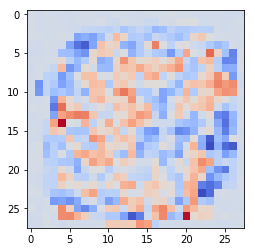

In [32]:
plt.imshow(model[0].weight.data.cpu().numpy()[10, :].reshape((28, 28)), cmap=plt.cm.coolwarm)

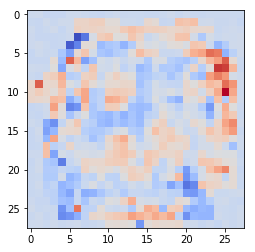

In [33]:
plt.imshow(model[0].weight.data.cpu().numpy()[12, :].reshape((28, 28)), cmap=plt.cm.coolwarm)